# Set Up

In [1]:
# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## MNIST 
En el libro se utiliza la función `fetch_mldata` que ya no funciona más con sklearn. Ahora se usa la función `fetch_openml` pero en esta es necesario ordenar los datos para obtener el mismo resultado que el libro.

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:,1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:,1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
# Fetch the data using sklearn and then sort the data as in the book
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)# This is how you fetch the dataset
    mnist.target = mnist.target.astype(np.int8) # Target are fetched as an array
    sort_by_target(mnist)
except ImportError:
    from sklearn.dataset import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
# Dataset dimensions
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

The datasets contains 70000 images 28x28 pixels (arrays of 784 elemnts). Also there's a 70000 labels vector.
if you explore more deeply you'll see that each elements of the data is a value between 0 and 255.

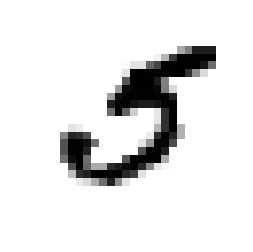

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest') 
# cmap for color and interpolation for definition
plt.axis('off')
plt.show()

In [6]:
y[36000]

5

In [7]:
# Dividing the data into trainset and testset 60000/10000
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# Shuffle the data / unsorting for cross-validation
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifiers
Evaluaremos la clasificación de si un número es 5 o no.

In [9]:
# Creating the boolean label for: 5 or not
y_train_5 = (y_train == 5) # Boolean label: True if it's a 5, False for all the others.
y_test_5 = (y_test == 5)

### SDG Classifier

In [10]:
# Call, and train the classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42) # max_iter and tol just for same results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
# Evaluating the prediction in trained data
sgd_clf.predict([some_digit])

array([ True])

## Perfomance Measures

In [12]:
# Accuracy of the classifier
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

Tiene sobre 95% de **accuracy** en todas las folds.
Intentemos con un clasificador que nunca entregue 5.

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
# Accuracy of naive classifier to show skewed data problems with accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

Se observa que para **skewed data** no es conveniente usar el accuracy.
Intentaremos ahora con la **Confusion Matrix**.

### Confusion Matrix

In [15]:
# Predictions for confusion matrix and so on.
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

### Precision, Recall and F1

In [17]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), 4344/(4344+1307), recall_score(y_train_5, y_train_pred), 4344/(4344+1077)

(0.7687135020350381, 0.7687135020350381, 0.801328168234643, 0.801328168234643)

El clasificador estará contestando correctamente un 76,8% y solo detectara el 80,1% de los números 5. En el resultado superior se puede ver como la fórmula implementada en scikit es igual a la fórmula matemática.

Podemos calcular también el **F1 Score**, que es una combinación entre ambas métricas.

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

Es posible también aumentar el threshold para poder ganar precisión (perdiendo recall) o disminuirlo para aumentar el recall (disminuyendo la precisión). La función siguiente entrega el score de cierta data.

In [19]:
# Score for some random digit
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [20]:
# Changing the threshold to a higher value
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Como elegir un buen threshold? Podemos graficar las funciones precision and recall. La siguiente función nos entrega los scores de cada uno de los datos. 

**While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.**

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

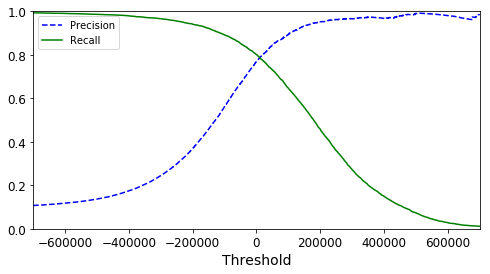

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plt.figure(figsize=(8,4)) # wider graph
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000]) #put x limits to the plot
plt.show() 

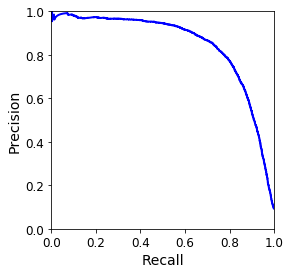

In [24]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(4, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

La precisión comienza a caer drásticamente justo antes del 80% porciento de recall. En este caso una buena opción sería tomar un valor justo antes de que esto ocurra.

Veámos como funciona cuando tomamos un 90% precision

In [25]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.8659205116491548, 0.6993174691016417)

### ROC Curve

Esta curva grafíca el true positive rate (recall) sobre el flase positive rate (falsa alarma) mientras se cambia el threshold.
$$
TPR = \frac{TP}{TP+FN}=Recall\quad,\quad FPR = \frac{FP}{FP+TN}
$$


In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

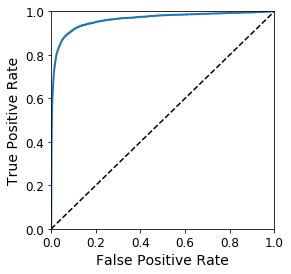

In [27]:
def plot_roc_curve(ftp, tpr, label=None): # Label added for plot also the randomforest
    plt.plot(ftp, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--', label=label) # Random Classifier
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plt.figure(figsize=(4, 4))
plot_roc_curve(fpr, tpr)
plt.show()

Queremos estar tan lejos de la linea del random classifier como se pueda hacia la izquierda-arriba. Otra medida útil es el **ROC AUC (*roc area under curve*)** en donde un clasificador perfecto tendría ROC AUC 1 mientras que un random tendría 0.5

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

PR curve: se usa cuando hay pocos elementos dentro de la positive class o cuando nos importan más los falsos positivos que los falsos negativos. ROC se usa en el caso contrario.
**Ver cual es más rigurosa usando el área bajo la curva.**

Comparemos los resultados de este clasificador con un RandomForestClassifier. Scikit classifiers tienen generalmente una ``decision_funcion()`` o un ``predicted_proba()`` method. RandomForest tiene la segunda.

In [29]:
# Call and train the classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

RandomForest entrega dos probabilidades para cada uno de los elementos, en este caso, una de que no sea 5 y una de que sea 5. Estas probabilidades quedan en y_probas_forest que se entreno con una cross validation de 3-folds.
Para transforar probabilidades en score, solo basta con tomar la probabilidad positiva (scores entre 0 y 1) y para calcular fpr y tpr simplemente mover un threshold entre 0 y 1.

In [30]:
y_scores_forest = y_probas_forest[:, 1] #Positive class of the random forest
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_scores_forest)

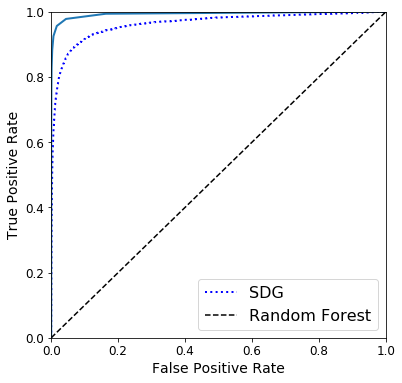

In [31]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SDG")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

Si queremos calcular la precisión y el recall tenemos que obtener las prediciones y para esto elegir un threshold o simplemente dejar que cross validation lo escoja.

In [33]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9852973447443494, 0.8282604685482383)

# Multiclass Classification

Multiclass o multinomial classification es clasificar en más de dos grupos. Algunos algoritmos solo permiten clasificar de manera binaria sin embargo se pueden hacer modifcaciones en el entrenamiento para lograr que clasifiquen en varias clases.

- **OvA (One vs All)**: en este caso se entrena un clasificador binario para que logre diferenciar entre una clase y el resto para cada una de las clases que hay. En MNIST, serían 10 clases. Este tipo de entrenamiento es el más utilizado y Scikit reconoce automáticamente cuando se usa un binario para clasificar multiclass y utiliza este método de entrenamiento en casi todos los algoritmos.

- **OvO**: este caso entrena binario entre cada clase creando así $\sum_i^n{n-i}$ entrenamientos. En MNIST serían 45 clasificadores. Su ventaja es que los set de entrenamiento son más pequeños (solo con las clases que se están clasificando y por ejemplo para Support Vector Machine funciona mejor.

In [34]:
# Train and prediction for a SGD Classifier with multiclass using predifined OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [35]:
# Score values for each classifier trained by the algorithm, ie 10 differents values
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [36]:
# Extracting the max value index for determine the class according the classifier
index = np.argmax(some_digit_scores)
sgd_clf.classes_[index]

5

In [37]:
# Forcing Sklearn to use OvO instead of OvA training
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

array([5], dtype=int8)

In [38]:
len(ovo_clf.estimators_) # Numbers of clf trained using OvO

45

In [39]:
# Training a RandomForest
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [40]:
# Probability of the digit to belong to each class
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [41]:
# Scoring the SGD algorithm trained with OvA
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

Siempre es importante comparar estos resultados con los valores de un naive classificator. En este caso, random lograría un 10% de accuracy por lo que sobre 80% en el clasificador es bastante bueno.

In [42]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.94041192, 0.93879694, 0.93949092])

In [43]:
# Using scaling in the images helps to improve the clf
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

# Error Analysis 

En un problema real, uno de los pasos impotantes una vez elegido el modelo es el estudio de los errores del clf.
Para esto, la confusion matrix resulta ser una herramienta de gran utilidad.

In [44]:
# Train the model with all the data and get conf_mx
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5604,    2,   81,   25,    8,   44,   32,    9,  115,    3],
       [   1, 6292,   72,   54,   20,   22,    8,    8,  262,    3],
       [  59,   73, 5016,  218,   68,   25,   82,   58,  344,   15],
       [  40,   16,  148, 5315,   19,  199,   23,   41,  297,   33],
       [  24,   26,  145,   39, 4746,   22,   63,   49,  502,  226],
       [  73,   25,   74,  375,   62, 3868,   91,   22,  771,   60],
       [  50,   19,  128,   13,   84,  105, 5369,    8,  140,    2],
       [  65,   19,   69,  117,  100,   18,    2, 5641,  112,  122],
       [  47,   96,  127,  196,   77,  135,   30,   23, 5088,   32],
       [  58,   45,   59,  199,  233,   59,    2,  385,  725, 4184]])

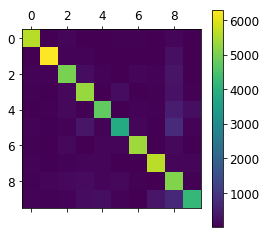

In [45]:
# Fucntion for color ploting
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111) # 1x1 Grid 1st subplot
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_mx)

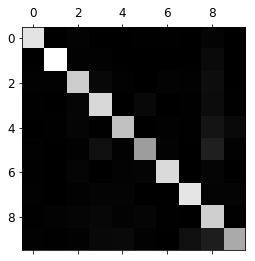

In [46]:
# Simple plot with gray scale
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

En general se puede ver que los valores estan en su mayoría sobra la diagonal lo que indíca que el clf logró identificar correctamente las clases de los números.
Sin embargo, hay algunos cuadros más oscuros en la diagonal y unos más claros en fuera, por ejemplo en el número 5.
Es importante entender las posibles causas: la más obvia missclassification, sin embargo también puede deberse a que de esa clase hay menos datos, por eso siempre es importante normalizar.

Para normalizar necesitamos dividir cada cuadro por el total de valores en su clase. Recordar que **las filas indican las clases reales mientras las columnas las clases estimadas por el clasificador**

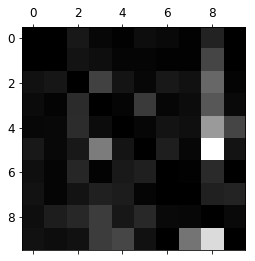

In [47]:
row_sum = conf_mx.sum(axis=1, keepdims=True) # Total elements by class
norm_conf_mx = conf_mx / row_sum # Normalized confusion matrix
np.fill_diagonal(norm_conf_mx, 0) # Eliminate the diagonal (good clf)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Con respecto a esta imagen se observa que varios números fueron confundidos con el 8. En especial el 9 y el 5. 
También se observa como el 5 ha sido varias veces confundido con el 3. Dentro del análisis de errores también se pueden estudiar en casos individuales pero esto tarda más.

# Multilabel Classification

Este tipo de clasificación es cuando se desea que el output no sea solamente una clase sino que varias. El mejor ejemplo es el face recognition en donde en una foto debe entregar a toda la gente presente en ella.
No todos los clf pueden entregar estos resultados.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [49]:
knn_clf.predict([some_digit])

array([[False,  True]])

El resultado anterior significa que el digito 5 a predecir, no es un número grande y es impar.

Para ver el rendimiento de un clasificador multilabel se pueden utilizar varias metricas incluso la de los binarios como F1. Para esto se calcula el F1 para cada una de las clases y luego se promedian.
``` python
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1) # n_jobs = nº of CPUs
f1_score(y_multilabel, y_trian_knn_pred, average="macro")
```

# Multioutput Classification

Este es un tipo de multilabel classification pero más general. El output en este caso puede ser más de una etiqueta por instancia. 

In [50]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

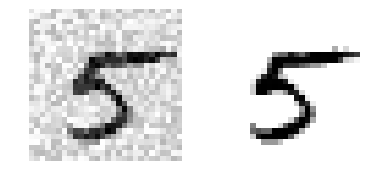

In [51]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis("off")
    
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

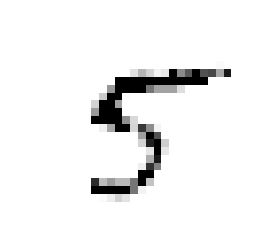

In [52]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Problems

**1.- Trytobuild a classifier for the MNIST dataset that achieve sover 97% accuracy on the test set. 
Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).**

For this problem as the hint says we are going to use GridSearchCV that is a fucntion that implements a fit and score according to the param_grid argument. This arg is a dictionary with the options you want to train and compare the model.

KNeighborsClassifier has 3 possibles weights arg.
1.- uniform: trains with the same weights for all the elements in a neighbourhood
2.- distance: evaluate the weight according the distance
3.- custom: use a custom weight function
In this case we are going to test just the 2 first.

Also we compare how the algorithm performs evaluating 3, 4 or 5 neigbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_scores_

The accuracy score is the correct prediction over the total.
$$
accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

**2.- Data Augmentation**

Remebering a little of the algebra class a shift matrix is a matrix with a supra o subdiagonal with ones but with zeros in the elsewhere. A supradiagonal matrix will shif the image upper while his transpose will shif the matrix down.
If S is a supradiagonal matrix

- $SA$ = shif upper
- $S^{T}A$ = shift down
- $AS$ = shift left
- $AS^{T}$ = shift right

Scipy has already a function for shift. It's also possibe to use OpenCV library for this task. This webpage has a lot of good information for image preprocesing.
https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=warpaffine

In [53]:
from scipy.ndimage.interpolation import shift

In [54]:
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    # cval:what we put in past edges, mode:approx
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1]) # Vector transformation

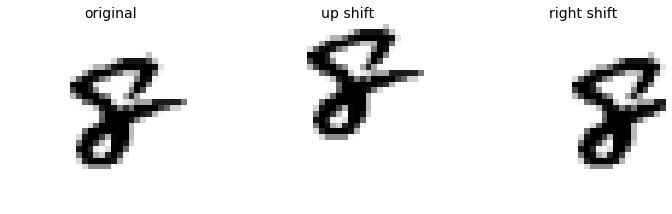

In [56]:
image = X_train[1000]
shift_up = shift_image(image, 0, -5)
shift_right = shift_image(image, 5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("original", fontsize=14)
plot_digit(image)
plt.subplot(132)
plt.title("up shift", fontsize=14)
plot_digit(shift_up)
plt.subplot(133)
plt.title("right shift", fontsize=14)
plot_digit(shift_right)
plt.show()

In [63]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    # zip() for parallel iterations
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [64]:
#Shuffle the data helps to eliminate the fixed learning
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]